In [1]:
# config
import common.init as init
from singleton_pattern.load_model import get_model
from  singleton_pattern.load_config import get_config,get_non_dnn_method_list
from singleton_pattern.load_dataset_reader import get_train_reader,get_test_reader
from singleton_pattern.load_data_generator import get_train_data_generator,get_test_data_generator
from common.cache import Cache
from common.cuda_info import get_device
from common.cache import CacheType
config_name = 'PhysNet.yaml'
# init
init.run(config_name)

CUDA:
---------------------------
PyTorch supports GPU and currently has 1 CUDA devices available.
The current default CUDA device is: NVIDIA GeForce RTX 3090
---------------------------
Method and DataGenerator Name: PhysNet


In [2]:
config = get_config()
non_dnn_method_list = get_non_dnn_method_list()
model = get_model()
is_need_train = config['method'] not in non_dnn_method_list
# load test dataset
test_reader = get_test_reader()
test_data_generator = get_test_data_generator()
print(f'Test Loader: {test_reader.loader_name}')
test_data = test_reader.load_data()
test_dataloader = test_data_generator.get_tensor_dataloader(test_data)

Test Loader: UBFC_Phys
Root Path:D:\dataset\compression\UBFC-PHYs_test
Start Reading UBFC_Phys Dataset Directory...


Progress:   0%|          | 0/1 [00:00<?, ?it/s]

cache path:cache\TEST\0e184c4d62fd314096cb4b8bc2746cb72c51cc2ae98853f3a4a21152c9f3ed1b
Start Generator Data...


Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Processing videos 1 :   0%|          | 0/2108 [00:00<?, ?it/s]

dataset size: 51


train_reader: UBFC_Phys
Root Path:D:\dataset\compression\UBFC-PHYs_test
Start Reading UBFC_Phys Dataset Directory...


Progress:   0%|          | 0/1 [00:00<?, ?it/s]

cache path:cache\TRAIN\0e184c4d62fd314096cb4b8bc2746cb72c51cc2ae98853f3a4a21152c9f3ed1b
Start Generator Data...


Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Processing videos 1 :   0%|          | 0/2108 [00:00<?, ?it/s]

dataset size: 51
optimizer:Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
criterion:PhyNetLoss(
  (neg_pearson_Loss): NegPearsonLoss(
    (pearson): PearsonLoss()
  )
)


Progress:   0%|          | 0/500 [00:00<?, ?it/s]

cache path:cache\MODEL\
Epoch [1/500],Train Loss: 1.0190,Test Loss: 0.9949
Epoch [2/500],Train Loss: 0.9959,Test Loss: 0.9768
Epoch [3/500],Train Loss: 0.9858,Test Loss: 0.9427
Epoch [4/500],Train Loss: 0.9781,Test Loss: 0.9244
Epoch [5/500],Train Loss: 0.9527,Test Loss: 0.9380
Epoch [6/500],Train Loss: 0.9463,Test Loss: 0.8928
Epoch [7/500],Train Loss: 0.9952,Test Loss: 0.9455
Epoch [8/500],Train Loss: 0.9324,Test Loss: 0.9032
Epoch [9/500],Train Loss: 0.9228,Test Loss: 0.8725
Epoch [10/500],Train Loss: 0.9146,Test Loss: 0.8739
Epoch [11/500],Train Loss: 0.9013,Test Loss: 0.8586
Epoch [12/500],Train Loss: 0.8907,Test Loss: 0.8303
Epoch [13/500],Train Loss: 0.8801,Test Loss: 0.8502
Epoch [14/500],Train Loss: 0.8607,Test Loss: 0.8033
Epoch [15/500],Train Loss: 0.8733,Test Loss: 0.8036
Epoch [16/500],Train Loss: 0.8381,Test Loss: 0.8651
Epoch [17/500],Train Loss: 0.8326,Test Loss: 0.7732
Epoch [18/500],Train Loss: 0.8449,Test Loss: 0.7977
Epoch [19/500],Train Loss: 0.8960,Test Loss: 0.80

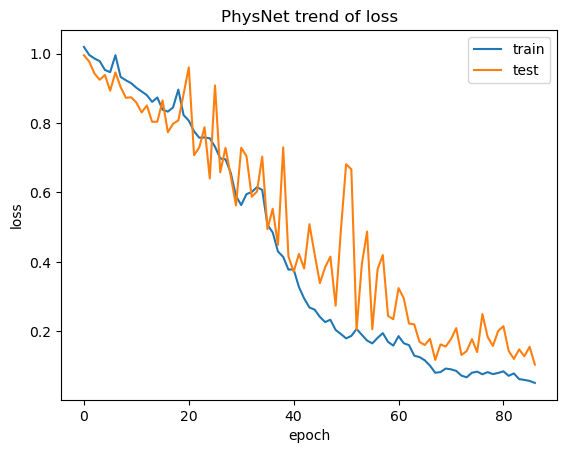

train end: best loss 0.0512, best test loss 0.1039, Epoch 87
train total time:  0h:10m:36s


In [3]:
train_dataloader = None
# load train dataset
if is_need_train:
    train_reader = get_train_reader()
    print(f'train_reader: {train_reader.loader_name}')
    train_data = train_reader.load_data()
    train_data_generator = get_train_data_generator()
    train_dataloader = train_data_generator.get_tensor_dataloader(train_data)

# if cached and want to second training, set train_twice = True
train_twice = False
# train
if not is_need_train:
    print('non train.')
else:
    from common.train_model import run as run_train
    if train_dataloader is None:
        raise Exception('load train dataloader first')
    if train_twice:
        cache_model = Cache(CacheType.MODEL).read_model()
        model.load_state_dict(cache_model.state_dict())
    run_train(model,train_dataloader,test_dataloader)